# Convolutional Neural Network

## Forward
---
- Zero Paddings
- Convolutional Layer
- Pooling

Zero Padding pads 0s at the edge of an image, benefits include:
- It allows you to use a CONV layer without necessarily shrinking the height and width of the volumes. This is important for building deeper networks, since otherwise the height/width would shrink as you go to deeper layers. An important special case is the "same" convolution, in which the height/width is exactly preserved after one layer. 

- It helps us keep more of the information at the border of an image. Without padding, very few values at the next layer would be affected by pixels as the edges of an image.

<img src="images/PAD.png" style="width:600px;height:400px;">

<caption><center>from Deep Learning Specilization Course</center></caption>

Consider an input of batched images with shape:

$$(m, n_W, n_H, n_C)$$

Where $m$ is the batch size, $n_W$ is the width of the image, $n_H$ is the height and $n_C$ is number of channels -- RGB would has 3 channels.

After padded with size $p$, the size would become

$$(m, n_W + 2p, n_H + 2p, n_C)$$

In [25]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

In [26]:
def zero_pads(X, pad):
    """
    X has shape (m, n_W, n_H, n_C)
    """
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    return X_pad

X shape (3, 4, 4, 3)
X_pad shape (3, 8, 8, 3)


Text(0.5, 1.0, 'paded')

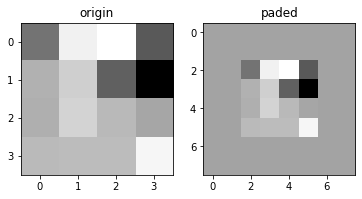

In [33]:
X = np.random.randn(3, 4, 4, 3)
X_pad = zero_pads(X, 2)

print('X shape', X.shape)
print('X_pad shape', X_pad.shape)

plt.subplot(1, 2, 1)
plt.imshow(X[0, :, :, 1], cmap='gray')
plt.title('origin')

plt.subplot(1, 2, 2)
plt.imshow(X_pad[0, :, :, 1], cmap='gray')
plt.title('paded')

In [22]:
W[:, :, 0]

array([[ 0.33946343,  0.66307695, -1.20873579,  0.19666875],
       [ 0.50748691, -2.97628012,  0.15474476, -0.50313565],
       [-0.57836561, -1.9060838 , -3.10431191, -0.77299851],
       [ 0.03800938,  0.46579028,  0.4333817 , -0.08089584]])

In [23]:
W[..., 0]

array([[ 0.33946343,  0.66307695, -1.20873579,  0.19666875],
       [ 0.50748691, -2.97628012,  0.15474476, -0.50313565],
       [-0.57836561, -1.9060838 , -3.10431191, -0.77299851],
       [ 0.03800938,  0.46579028,  0.4333817 , -0.08089584]])